## SIM Model

In [30]:
import torch
import torch.nn as nn
from torch.nn.modules.distance import CosineSimilarity
import numpy as np


class ParaModel(nn.Module):

    def __init__(self, args, vocab):
        super(ParaModel, self).__init__()

        self.args = args
        self.vocab = vocab
        self.gpu = args.gpu

        self.cosine = CosineSimilarity()

    def compute_mask(self, lengths):

        lengths = lengths.cpu()
        max_len = torch.max(lengths)
        range_row = torch.arange(0, max_len).long()[None, :].expand(lengths.size()[0], max_len)
        mask = lengths[:, None].expand_as(range_row)
        mask = range_row < mask
        mask = mask.float()
        if self.gpu >= 0:
            mask = mask.cuda()
        return mask

    def torchify_batch(self, batch):

        max_len = 0
        for i in batch:
            if len(i.embeddings) > max_len:
                max_len = len(i.embeddings)

        batch_len = len(batch)

        np_sents = np.zeros((batch_len, max_len), dtype='int32')
        np_lens = np.zeros((batch_len,), dtype='int32')

        for i, ex in enumerate(batch):
            np_sents[i, :len(ex.embeddings)] = ex.embeddings
            np_lens[i] = len(ex.embeddings)

        idxs, lengths, masks = torch.from_numpy(np_sents).long(), \
                               torch.from_numpy(np_lens).float().long(), \
                               self.compute_mask(torch.from_numpy(np_lens).long())

        if self.gpu >= 0:
            idxs = idxs.cuda()
            lengths = lengths.cuda()
            masks = masks.cuda()

        return idxs, lengths, masks

    def scoring_function(self, g_idxs1, g_mask1, g_lengths1, g_idxs2, g_mask2, g_lengths2):

        g1 = self.encode(g_idxs1, g_mask1, g_lengths1)
        g2 = self.encode(g_idxs2, g_mask2, g_lengths2)
        return self.cosine(g1, g2)

class WordAveraging(ParaModel):

    def __init__(self, args, vocab):
        super(WordAveraging, self).__init__(args, vocab)

        self.vocab = vocab
        self.embedding = nn.Embedding(len(self.vocab), self.args.dim)

        if args.gpu >= 0:
           self.cuda()

    def encode(self, idxs, mask, lengths):
        word_embs = self.embedding(idxs)
        word_embs = word_embs * mask[:, :, None]
        g = word_embs.sum(dim=1) / lengths[:, None].float()
        return g

## SIM utils

In [31]:
import io
import numpy as np
import torch

def get_wordmap(textfile):
    words={}
    We = []
    f = io.open(textfile, 'r', encoding='utf-8')
    lines = f.readlines()
    if len(lines[0].split()) == 2:
        lines.pop(0)
    ct = 0
    for (n,i) in enumerate(lines):
        word = i.split(' ', 1)[0]
        vec = i.split(' ', 1)[1].split(' ')
        j = 0
        v = []
        while j < len(vec):
            v.append(float(vec[j]))
            j += 1
        words[word] = ct
        ct += 1
        We.append(v)
    return words, np.array(We)

def get_minibatches_idx(n, minibatch_size, shuffle=False):
    idx_list = np.arange(n, dtype="int32")

    if shuffle:
        np.random.shuffle(idx_list)

    minibatches = []
    minibatch_start = 0
    for i in range(n // minibatch_size):
        minibatches.append(idx_list[minibatch_start:
                                    minibatch_start + minibatch_size])
        minibatch_start += minibatch_size

    if (minibatch_start != n):
        # Make a minibatch out of what is left
        minibatches.append(idx_list[minibatch_start:])

    return zip(range(len(minibatches)), minibatches)

def max_pool(x, lengths, gpu):
    out = torch.FloatTensor(x.size(0), x.size(2)).zero_()
    if gpu >= 0:
        out = out.cuda()
    for i in range(len(lengths)):
        out[i] = torch.max(x[i][0:lengths[i]], 0)[0]
    return out

def mean_pool(x, lengths, gpu):
    out = torch.FloatTensor(x.size(0), x.size(2)).zero_()
    if gpu >= 0:
        out = out.cuda()
    for i in range(len(lengths)):
        out[i] = torch.mean(x[i][0:lengths[i]], 0)
    return out

def lookup(words, w):
    w = w.lower()
    if w in words:
        return words[w]

class Example(object):

    def __init__(self, sentence):
        self.sentence = sentence.strip().lower()
        self.embeddings = []
        self.representation = None

    def populate_embeddings(self, words):
        sentence = self.sentence.lower()
        arr = sentence.split()
        for i in arr:
            emb = lookup(words, i)
            if emb:
                self.embeddings.append(emb)
        if len(self.embeddings) == 0:
            self.embeddings.append(words['UUUNKKK'])

## Similarity Evaluation

In [32]:
import torch
import numpy as np
from nltk.tokenize import TreebankWordTokenizer
import sentencepiece as spm


class SimilarityEvaluator:
    def __init__(
        self,
        model_path='/content/drive/MyDrive/sim.pt',
        tokenizer_path='/content/drive/MyDrive/sim.sp.30k.model',
        gpu=False
    ):
        self.model_path = model_path
        self.tokenizer_path = tokenizer_path
        self.tok = TreebankWordTokenizer()
        kw = {}
        if not torch.cuda.is_available():
            kw['map_location'] = torch.device('cpu')
        model = torch.load(self.model_path, **kw)
        state_dict = model['state_dict']
        vocab_words = model['vocab_words']
        args = model['args']
        if gpu is False:
            args.gpu = -1
        # turn off gpu
        self.model = WordAveraging(args, vocab_words)
        self.model.load_state_dict(state_dict, strict=True)
        self.sp = spm.SentencePieceProcessor()
        self.sp.Load(self.tokenizer_path)
        self.model.eval()

    def make_example(self, sentence):
        sentence = sentence.lower()
        sentence = " ".join(self.tok.tokenize(sentence))
        sentence = self.sp.EncodeAsPieces(sentence)
        wp1 = Example(" ".join(sentence))
        wp1.populate_embeddings(self.model.vocab)
        return wp1

    def find_similarity(self, s1, s2):
        with torch.no_grad():
            s1 = [self.make_example(x) for x in s1]
            s2 = [self.make_example(x) for x in s2]
            wx1, wl1, wm1 = self.model.torchify_batch(s1)
            wx2, wl2, wm2 = self.model.torchify_batch(s2)
            scores = self.model.scoring_function(wx1, wm1, wl1, wx2, wm2, wl2)
            return [x.item() for x in scores]

    def find_similarity_batched(self, inputs, preds, batch_size=32):
        assert len(inputs) == len(preds)
        sim_scores = []
        for i in range(0, len(inputs), batch_size):
            sim_scores.extend(
                self.find_similarity(inputs[i:i + batch_size], preds[i:i + batch_size])
            )
        return np.array(sim_scores)

    def embed_texts(self, texts, batch_size=128):
        result = []
        for i in range(0, len(texts), batch_size):
            wx, wl, wm = self.model.torchify_batch([self.make_example(x) for x in texts[i:i+batch_size]])
            with torch.no_grad():
                tensors = torch.nn.functional.normalize(self.model.encode(wx, wm, wl))
            result.append(tensors.cpu().numpy())
        return np.concatenate(result)


In [20]:
pip install fairseq


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 25.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.3/288.3 kB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 17.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia

In [35]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Specify the name or path of the pre-trained CoLA classifier
cola_classifier_name = "bert-base-uncased"

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(cola_classifier_name)
model = AutoModelForSequenceClassification.from_pretrained(cola_classifier_name)

# Save the model and tokenizer to a directory
model.save_pretrained("/content/drive/MyDrive")
tokenizer.save_pretrained("/content/drive/MyDrive")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


('/content/drive/MyDrive/tokenizer_config.json',
 '/content/drive/MyDrive/special_tokens_map.json',
 '/content/drive/MyDrive/vocab.txt',
 '/content/drive/MyDrive/added_tokens.json',
 '/content/drive/MyDrive/tokenizer.json')

In [39]:
input_file_path = "/content/drive/MyDrive/test_10k_toxic"
preds_file_path = "/content/drive/MyDrive/paragedi_with_mined_paraphraser.txt"

with open(input_file_path, 'r') as input_file, open(preds_file_path, 'r') as preds_file:
    inputs = input_file.readlines()
    preds = preds_file.readlines()
print(len(preds))

10000


In [41]:
print(f'Mined\n')

Mined



In [44]:
import os
import gc
import tqdm
import torch
import argparse
import numpy as np

from nltk.translate.bleu_score import sentence_bleu
from tqdm.auto import trange



from transformers import AutoModelForSequenceClassification, AutoTokenizer, RobertaTokenizer, RobertaForSequenceClassification

from fairseq.models.roberta import RobertaModel
from fairseq.data.data_utils import collate_tokens


def cleanup():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()


def classify_preds(args, preds, soft=False):
    print('Calculating style of predictions')
    model_name = args.classifier_path or 'SkolkovoInstitute/roberta_toxicity_classifier'
    tokenizer = RobertaTokenizer.from_pretrained(model_name)
    model = RobertaForSequenceClassification.from_pretrained(model_name)
    results = []

    for i in tqdm.tqdm(range(0, len(preds), args.batch_size)):
        batch = tokenizer(preds[i:i + args.batch_size], return_tensors='pt', padding=True)
        with torch.inference_mode():
            logits = model(**batch).logits
        if soft:
            result = torch.softmax(logits, -1)[:, 1].cpu().numpy()
        else:
            result = (logits[:, 1] > args.threshold).cpu().numpy()
        results.extend([1 - item for item in result])
    return results


def calc_bleu(inputs, preds):
    bleu_sim = 0
    counter = 0
    print('Calculating BLEU similarity')
    for i in range(len(inputs)):
        if len(inputs[i]) > 3 and len(preds[i]) > 3:
            bleu_sim += sentence_bleu([inputs[i]], preds[i])
            counter += 1

    return float(bleu_sim / counter)


def wieting_sim(args, inputs, preds):
    assert len(inputs) == len(preds)
    print('Calculating similarity by Wieting subword-embedding SIM model')

    sim_evaluator = SimilarityEvaluator()

    sim_scores = []

    for i in tqdm.tqdm(range(0, len(inputs), args.batch_size)):
        sim_scores.extend(
            sim_evaluator.find_similarity(inputs[i:i + args.batch_size], preds[i:i + args.batch_size])
        )

    return np.array(sim_scores)


def detokenize(x):
    return x.replace(" .", ".").replace(" ,", ",").replace(" !", "!").replace(" ?", "?").replace(" )",")").replace("( ", "(")  # noqa


def do_cola_eval(args, preds, soft=False):
    print('Calculating CoLA acceptability stats')

    path_to_data = os.path.join(args.cola_classifier_path, 'cola-bin')

    cola_roberta = RobertaModel.from_pretrained(
        args.cola_classifier_path, checkpoint_file=args.cola_checkpoint, data_name_or_path=path_to_data
    )
    cola_roberta.eval()
    if torch.cuda.is_available():
        cola_roberta.cuda()

    cola_stats = []

    for i in tqdm.tqdm(range(0, len(preds), args.batch_size), total=len(preds) // args.batch_size):
        sentences = preds[i:i + args.batch_size]

        # detokenize and BPE encode input
        sentences = [cola_roberta.bpe.encode(detokenize(sent)) for sent in sentences]

        batch = collate_tokens(
            [cola_roberta.task.source_dictionary.encode_line("<s> " + sent + " </s>", append_eos=False)
             for sent in sentences],
            pad_idx=1
        )

        batch = batch[:, :512]

        with torch.no_grad():
            predictions = cola_roberta.predict('sentence_classification_head', batch.long())

        if soft:
            prediction_labels = torch.softmax(predictions, axis=1)[:, 1].cpu().numpy()
        else:
            prediction_labels = predictions.argmax(axis=1).cpu().numpy()
        # label 0 means acceptable. Need to inverse
        cola_stats.extend(list(1 - prediction_labels))

    return np.array(cola_stats)


def do_cola_eval_transformers(args, preds, soft=False):
    print('Calculating CoLA acceptability stats')
    path = args.cola_classifier_path

    model = AutoModelForSequenceClassification.from_pretrained(path)
    tokenizer = AutoTokenizer.from_pretrained(path)

    results = []
    bs = args.batch_size
    for i in trange(0, len(preds), bs):
        batch = [detokenize(t) for t in preds[i: i + bs]]
        inputs = tokenizer(batch, padding=True, truncation=True, return_tensors='pt').to(model.device)
        with torch.no_grad():
            out = torch.softmax(model(**inputs).logits, -1)[:, 0].cpu().numpy()
            if soft:
                results.append(out)
            else:
                results.append((out > 0.5).astype(int))
    return np.concatenate(results)



if __name__ == "__main__":
    input_file_path = "/content/drive/MyDrive/test_10k_toxic"
    preds_file_path = "/content/drive/MyDrive/paragedi_with_mined_paraphraser.txt"

    with open(input_file_path, 'r') as input_file, open(preds_file_path, 'r') as preds_file:
        inputs = input_file.readlines()
        preds = preds_file.readlines()

    args = argparse.Namespace()
    args.classifier_path = None  # Update with the appropriate classifier path
    args.threshold = 0.8  # Update with the appropriate threshold
    args.batch_size = 32  # Update with the appropriate batch size

    # accuracy of style transfer
    accuracy_by_sent = classify_preds(args, preds)
    accuracy = sum(accuracy_by_sent) / len(preds)
    cleanup()

    # similarity
    bleu = calc_bleu(inputs, preds)

    similarity_by_sent = wieting_sim(args, inputs, preds)
    avg_sim_by_sent = similarity_by_sent.mean()
    cleanup()

    # fluency
    # cola_stats = do_cola_eval(args, preds)
    # cola_acc = sum(cola_stats) / len(preds)
    # cleanup()
    print('| Model | ACC | SIM |\n')
    print('| ----- | --- | --- |\n')
    print(f'Mined|{accuracy:.4f}|{avg_sim_by_sent:.4f}|\n')
    cola_acc = 0.83
    # count metrics
    joint = (sum(accuracy_by_sent) * sum(similarity_by_sent) * cola_acc) / len(preds)

    # write res to table
    # name = args.preds.split('/')[-1]
    print('| Model | ACC | SIM | FL | J | BLEU |\n')
    print('| ----- | --- | --- | -- | - | ---- |\n')
    print(f'Mined|{accuracy:.4f}|{avg_sim_by_sent:.4f}|{cola_acc:.4f}|{joint:.4f}|{bleu:.4f}|\n')


Calculating style of predictions


Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 313/313 [18:07<00:00,  3.48s/it]


Calculating BLEU similarity
Calculating similarity by Wieting subword-embedding SIM model


100%|██████████| 313/313 [00:03<00:00, 90.28it/s]


| Model | ACC | SIM |

| ----- | --- | --- |

Mined|0.9840|0.6557|

| Model | ACC | SIM | FL | J | BLEU |

| ----- | --- | --- | -- | - | ---- |

Mined|0.9840|0.6557|0.8300|5355.0384|0.4528|



In [43]:
import os
import gc
import tqdm
import torch
import argparse
import numpy as np

from nltk.translate.bleu_score import sentence_bleu
from tqdm.auto import trange



from transformers import AutoModelForSequenceClassification, AutoTokenizer, RobertaTokenizer, RobertaForSequenceClassification

from fairseq.models.roberta import RobertaModel
from fairseq.data.data_utils import collate_tokens


def cleanup():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()


def classify_preds(args, preds, soft=False):
    print('Calculating style of predictions')
    model_name = args.classifier_path or 'SkolkovoInstitute/roberta_toxicity_classifier'
    tokenizer = RobertaTokenizer.from_pretrained(model_name)
    model = RobertaForSequenceClassification.from_pretrained(model_name)
    results = []

    for i in tqdm.tqdm(range(0, len(preds), args.batch_size)):
        batch = tokenizer(preds[i:i + args.batch_size], return_tensors='pt', padding=True)
        with torch.inference_mode():
            logits = model(**batch).logits
        if soft:
            result = torch.softmax(logits, -1)[:, 1].cpu().numpy()
        else:
            result = (logits[:, 1] > args.threshold).cpu().numpy()
        results.extend([1 - item for item in result])
    return results


def calc_bleu(inputs, preds):
    bleu_sim = 0
    counter = 0
    print('Calculating BLEU similarity')
    for i in range(len(inputs)):
        if len(inputs[i]) > 3 and len(preds[i]) > 3:
            bleu_sim += sentence_bleu([inputs[i]], preds[i])
            counter += 1

    return float(bleu_sim / counter)


def wieting_sim(args, inputs, preds):
    assert len(inputs) == len(preds)
    print('Calculating similarity by Wieting subword-embedding SIM model')

    sim_evaluator = SimilarityEvaluator()

    sim_scores = []

    for i in tqdm.tqdm(range(0, len(inputs), args.batch_size)):
        sim_scores.extend(
            sim_evaluator.find_similarity(inputs[i:i + args.batch_size], preds[i:i + args.batch_size])
        )

    return np.array(sim_scores)


def detokenize(x):
    return x.replace(" .", ".").replace(" ,", ",").replace(" !", "!").replace(" ?", "?").replace(" )",")").replace("( ", "(")  # noqa


def do_cola_eval(args, preds, soft=False):
    print('Calculating CoLA acceptability stats')

    path_to_data = os.path.join(args.cola_classifier_path, 'cola-bin')

    cola_roberta = RobertaModel.from_pretrained(
        args.cola_classifier_path, checkpoint_file=args.cola_checkpoint, data_name_or_path=path_to_data
    )
    cola_roberta.eval()
    if torch.cuda.is_available():
        cola_roberta.cuda()

    cola_stats = []

    for i in tqdm.tqdm(range(0, len(preds), args.batch_size), total=len(preds) // args.batch_size):
        sentences = preds[i:i + args.batch_size]

        # detokenize and BPE encode input
        sentences = [cola_roberta.bpe.encode(detokenize(sent)) for sent in sentences]

        batch = collate_tokens(
            [cola_roberta.task.source_dictionary.encode_line("<s> " + sent + " </s>", append_eos=False)
             for sent in sentences],
            pad_idx=1
        )

        batch = batch[:, :512]

        with torch.no_grad():
            predictions = cola_roberta.predict('sentence_classification_head', batch.long())

        if soft:
            prediction_labels = torch.softmax(predictions, axis=1)[:, 1].cpu().numpy()
        else:
            prediction_labels = predictions.argmax(axis=1).cpu().numpy()
        # label 0 means acceptable. Need to inverse
        cola_stats.extend(list(1 - prediction_labels))

    return np.array(cola_stats)


def do_cola_eval_transformers(args, preds, soft=False):
    print('Calculating CoLA acceptability stats')
    path = args.cola_classifier_path

    model = AutoModelForSequenceClassification.from_pretrained(path)
    tokenizer = AutoTokenizer.from_pretrained(path)

    results = []
    bs = args.batch_size
    for i in trange(0, len(preds), bs):
        batch = [detokenize(t) for t in preds[i: i + bs]]
        inputs = tokenizer(batch, padding=True, truncation=True, return_tensors='pt').to(model.device)
        with torch.no_grad():
            out = torch.softmax(model(**inputs).logits, -1)[:, 0].cpu().numpy()
            if soft:
                results.append(out)
            else:
                results.append((out > 0.5).astype(int))
    return np.concatenate(results)



if __name__ == "__main__":
    input_file_path = "/content/drive/MyDrive/test_10k_toxic"
    preds_file_path = "/content/drive/MyDrive/paragedi_with_default_paraphraser.txt"

    with open(input_file_path, 'r') as input_file, open(preds_file_path, 'r') as preds_file:
        inputs = input_file.readlines()
        preds = preds_file.readlines()

    args = argparse.Namespace()
    args.classifier_path = None  # Update with the appropriate classifier path
    args.threshold = 0.8  # Update with the appropriate threshold
    args.batch_size = 32  # Update with the appropriate batch size

    # accuracy of style transfer
    accuracy_by_sent = classify_preds(args, preds)
    accuracy = sum(accuracy_by_sent) / len(preds)
    cleanup()

    # similarity
    bleu = calc_bleu(inputs, preds)

    similarity_by_sent = wieting_sim(args, inputs, preds)
    avg_sim_by_sent = similarity_by_sent.mean()
    cleanup()

    # fluency
    # cola_stats = do_cola_eval(args, preds)
    # cola_acc = sum(cola_stats) / len(preds)
    # cleanup()
    print('| Model | ACC | SIM |\n')
    print('| ----- | --- | --- |\n')
    print(f'Regular|{accuracy:.4f}|{avg_sim_by_sent:.4f}|\n')
    cola_acc = 0.79
    # count metrics
    joint = (sum(accuracy_by_sent) * sum(similarity_by_sent) * cola_acc) / len(preds)

    # write res to table
    # name = args.preds.split('/')[-1]
    print('| Model | ACC | SIM | FL | J | BLEU |\n')
    print('| ----- | --- | --- | -- | - | ---- |\n')
    print(f'Regular|{accuracy:.4f}|{avg_sim_by_sent:.4f}|{cola_acc:.4f}|{joint:.4f}|{bleu:.4f}|\n')


Calculating style of predictions


Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 313/313 [18:05<00:00,  3.47s/it]


Calculating BLEU similarity
Calculating similarity by Wieting subword-embedding SIM model


100%|██████████| 313/313 [00:03<00:00, 91.74it/s]


| Model | ACC | SIM |

| ----- | --- | --- |

Regular|0.9432|0.6632|

| Model | ACC | SIM | FL | J | BLEU |

| ----- | --- | --- | -- | - | ---- |

Regular|0.9432|0.6632|0.7900|4941.6735|0.4678|



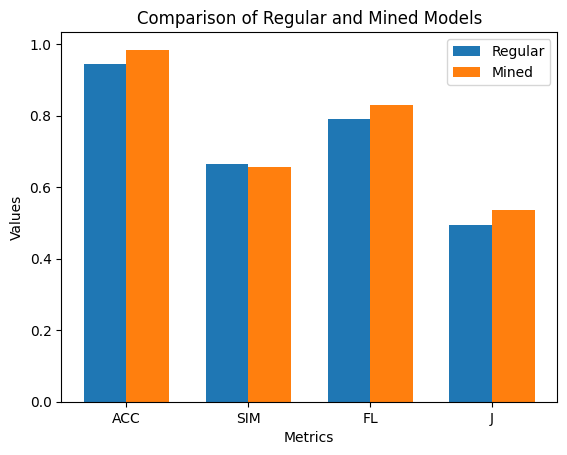

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Data for Regular model with J divided by 1000
regular_data = {
    'ACC': 0.9432,
    'SIM': 0.6632,
    'FL': 0.7900,
    'J': 4941.6735 / 10000  # Divide J by 1000
}

# Data for Mined model with J divided by 1000
mined_data = {
    'ACC': 0.9840,
    'SIM': 0.6557,
    'FL': 0.8300,
    'J': 5355.0384 / 10000  # Divide J by 1000
}

# Labels for x-axis
metrics = ['ACC', 'SIM', 'FL', 'J']

# Values for y-axis for each model
regular_values = [regular_data[m] for m in metrics]
mined_values = [mined_data[m] for m in metrics]

# Number of groups
num_metrics = len(metrics)

# Position of bars on the x-axis
bar_width = 0.35
x = np.arange(num_metrics)

# Create the bar plot
fig, ax = plt.subplots()
ax.bar(x - bar_width/2, regular_values, bar_width, label='Regular')
ax.bar(x + bar_width/2, mined_values, bar_width, label='Mined')

# Add labels, title, and legend
ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Comparison of Regular and Mined Models')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Show the plot
plt.show()
